**Importing** **library**

In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
def plt_images(orig_image, orig_title, processed_image, processed_title, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    ax1.set_title(orig_title, fontsize=30)
    ax1.imshow(orig_image)
    ax2.set_title(processed_title, fontsize=30)
    ax2.imshow(processed_image, cmap='gray')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280, 3)

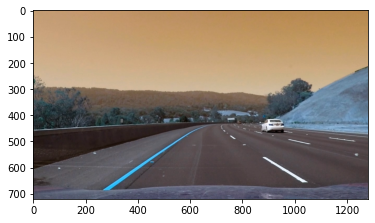

In [3]:
img = mpimg.imread("./images/test3.jpg") 
im = cv2.imread("./images/test3.jpg") 
plt.imshow(im)
img.shape

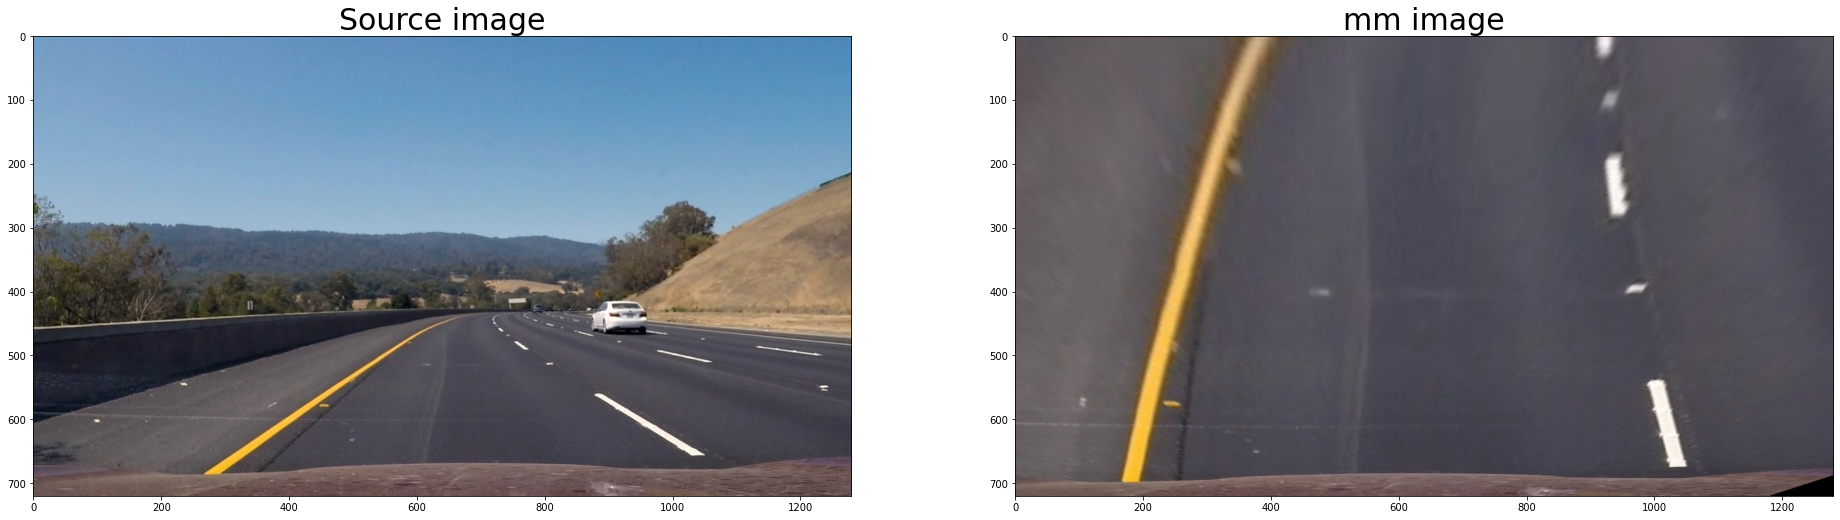

In [4]:
src = np.float32([(550, 460),     # top-left
                  (150, 720),     # bottom-left
                  (1200, 720),    # bottom-right
                  (770, 460)])  
dst = np.float32([(100, 0),
                 (100, 720),
                 (1100, 720),
                 (1100, 0)])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst,src)

img_size=(1280, 720)
flags=cv2.INTER_LINEAR
mm=cv2.warpPerspective(img,M, img_size, flags=flags)
#minv=cv2.warpPerspective(img, M_inv, img_size, flags=flags)
plt_images(img, 'Source image', mm, 'mm image')
#plt_images(img, 'Source image', minv, 'minv image')

[[ 85  87  89 ...  99  99  99]
 [ 86  86  88 ...  99  99  99]
 [ 87  86  86 ...  99  99  99]
 ...
 [104 105 108 ...   0   0   0]
 [107 105 105 ...   0   0   0]
 [107 106 106 ...   0   0   0]]


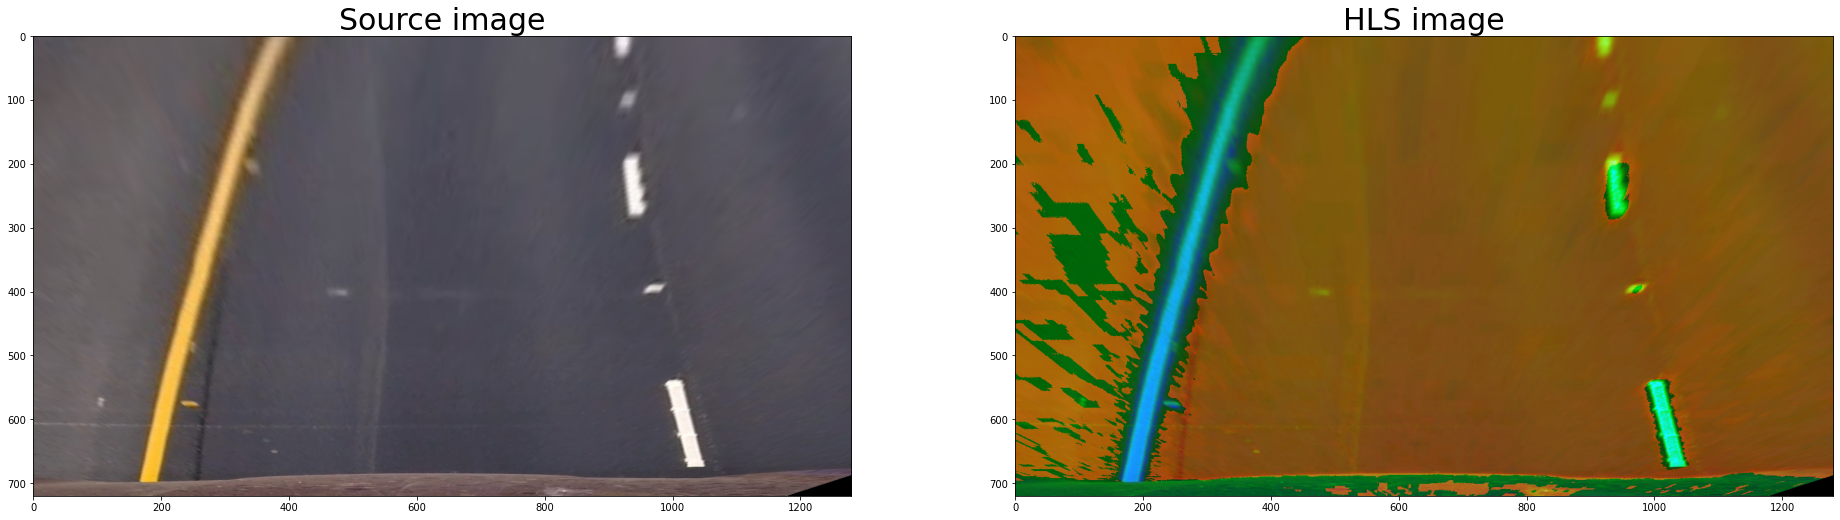

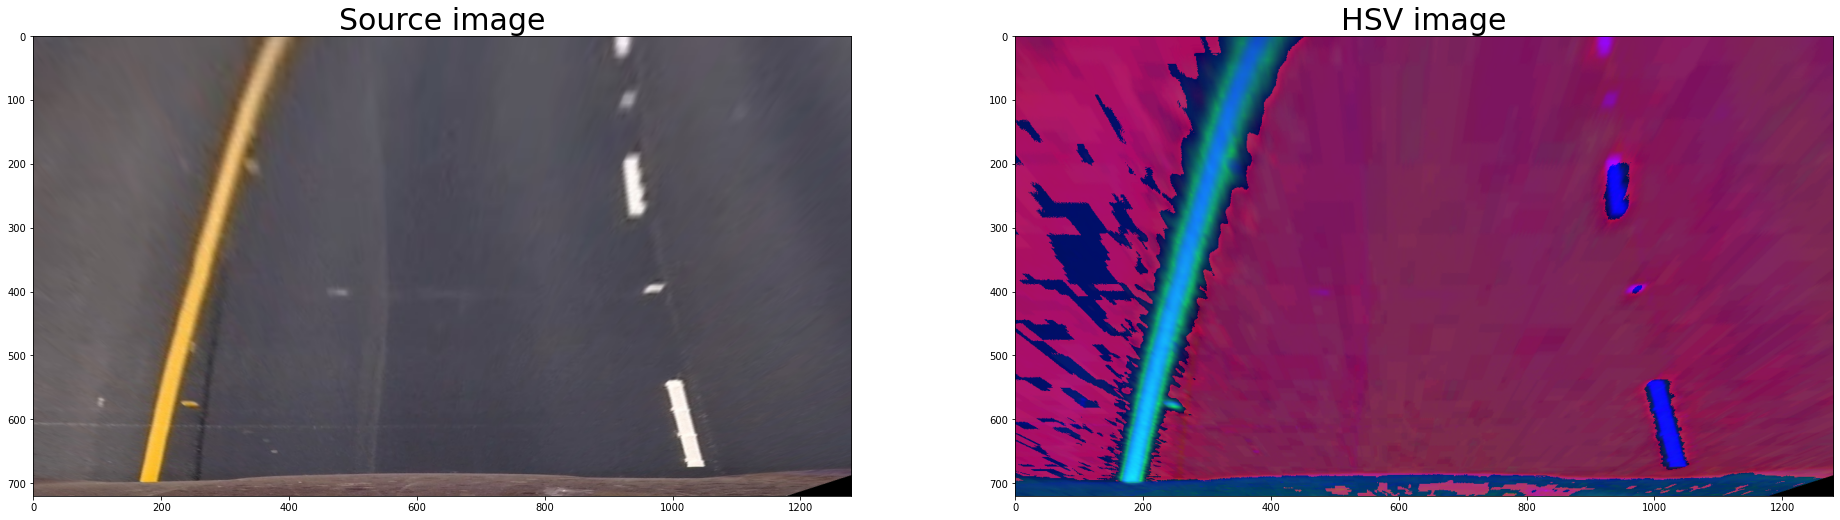

In [5]:
hls = cv2.cvtColor(mm, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(mm, cv2.COLOR_RGB2HSV)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
v_channel = hsv[:,:,2]
print(v_channel)
plt_images(mm, 'Source image', hls, 'HLS image')
plt_images(mm, 'Source image', hsv, 'HSV image')

**Thresholding function definition**


In [6]:
def threshold_rel(img, lo, hi):
  #getting the maximum and minimum pixels intesties
    vmin = np.min(img)
    print(vmin)
    vmax = np.max(img)
    print(vmax)
    
    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255


0
253


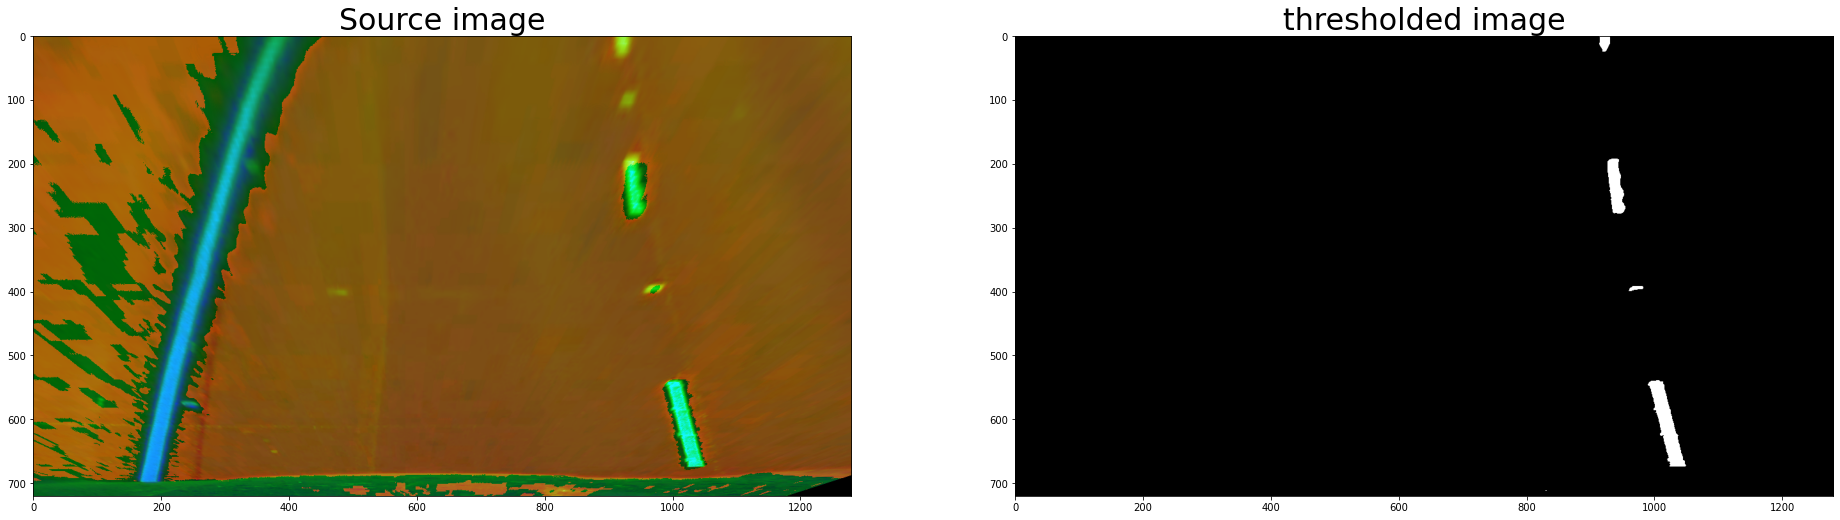

In [7]:
right_lane = threshold_rel(l_channel, 0.8, 1.0)
plt_images(hls, 'Source image', right_lane, 'thresholded image')

In [8]:
def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255

0
253
[[82 84 86 ... 95 95 95]
 [83 83 85 ... 95 95 95]
 [84 82 83 ... 95 95 95]
 ...
 [92 94 96 ...  0  0  0]
 [96 94 94 ...  0  0  0]
 [96 94 94 ...  0  0  0]]


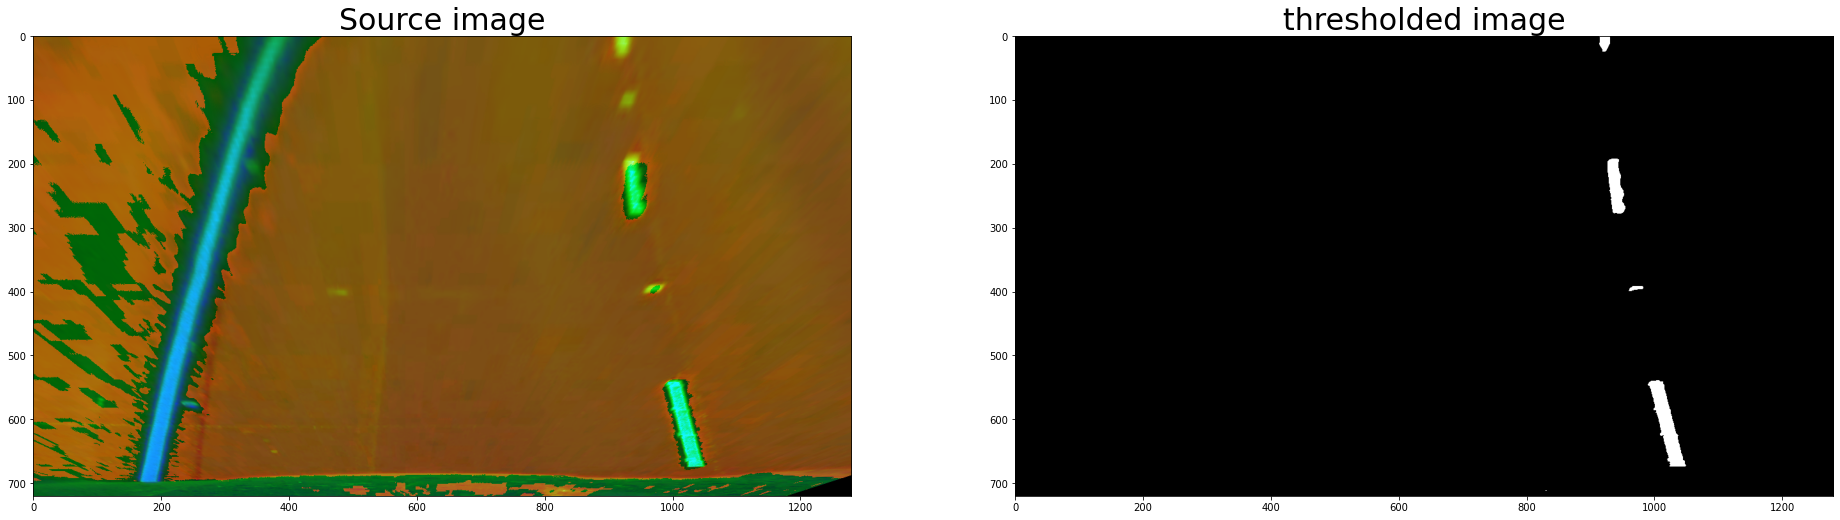

In [9]:
right_lane = threshold_rel(l_channel, 0.8, 1.0)
print(l_channel)
right_lane[:,:750] = 0
plt_images(hls, 'Source image', right_lane, 'thresholded image')


0
255


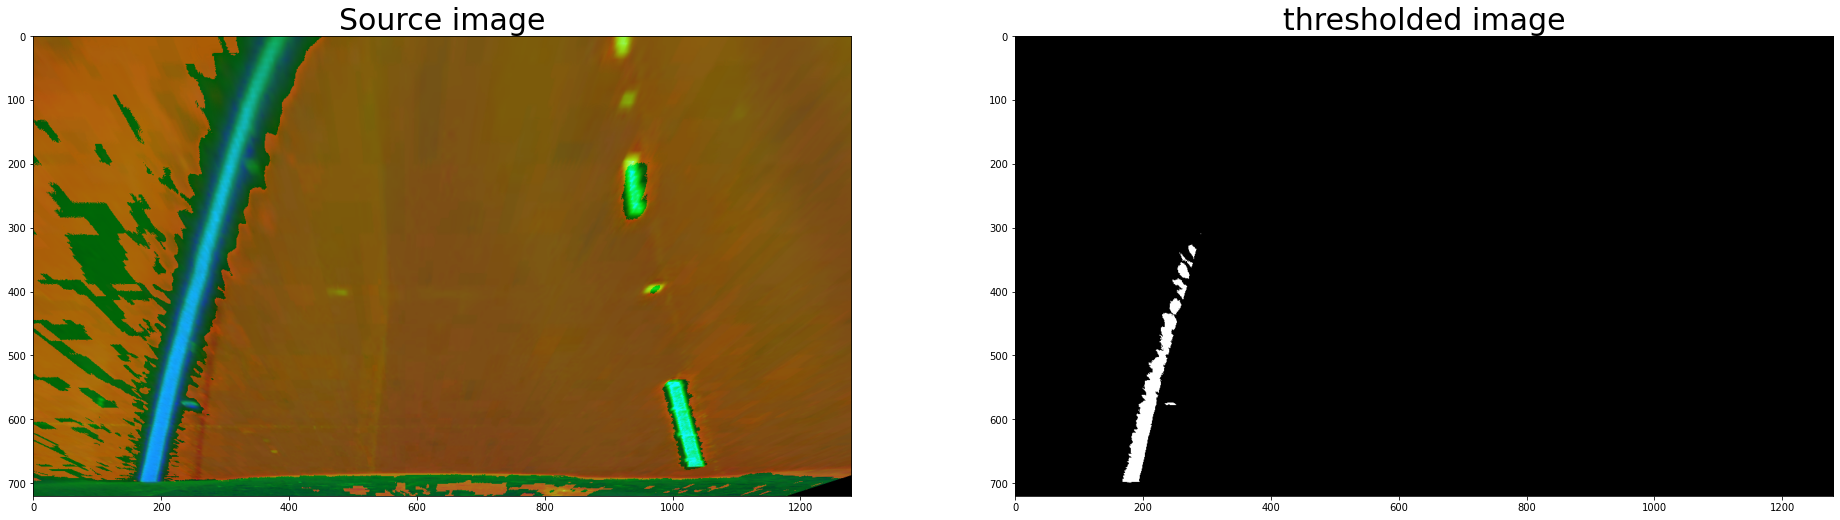

In [10]:
left_lane = threshold_abs(h_channel, 20, 30)
left_lane &= threshold_rel(v_channel, 0.7, 1.0)
left_lane[:,550:] = 0
plt_images(hls, 'Source image', left_lane, 'thresholded image')


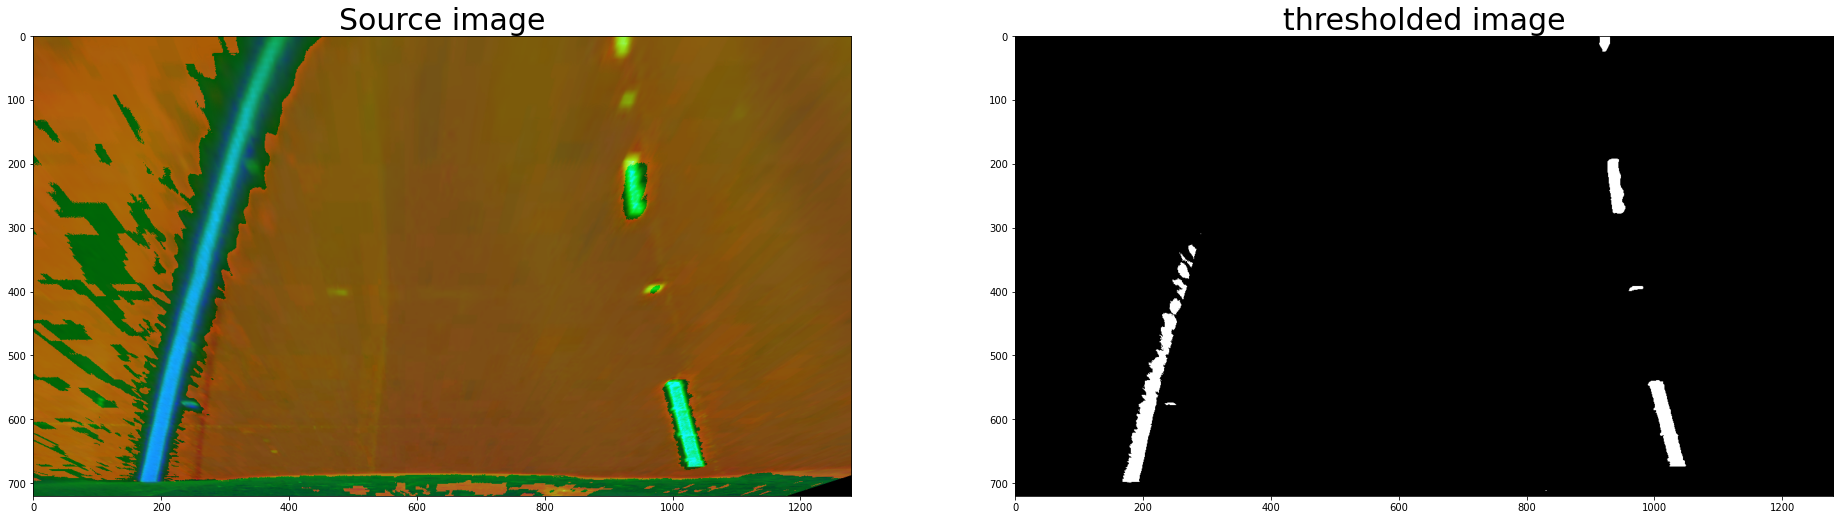

In [11]:
mm = left_lane | right_lane
plt_images(hls, 'Source image', mm, 'thresholded image')

In [12]:
#returns tuple of two arrays containing indecies of non zero pixels in the photo
nonzero = mm.nonzero()
nonzerox = np.array(nonzero[1])
nonzeroy = np.array(nonzero[0])

nwindows = 9
margin = 100
minpix = 50

window_height = np.int(img.shape[0]//nwindows)
print(nonzero)


(array([  0,   0,   0, ..., 698, 711, 711], dtype=int64), array([913, 914, 915, ..., 181, 829, 830], dtype=int64))


C:\Users\OMARNA~1\AppData\Local\Temp/ipykernel_9860/2300064984.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_height = np.int(img.shape[0]//nwindows)


In [14]:
#function that draws the histogram
def hist(img):
    #draws the histogram at the bottom half of the image
    bottom_half = img[img.shape[0]//2:,:]
    return np.sum(bottom_half, axis=0)

Leftx Base =  193 Rightx_Base =  1014


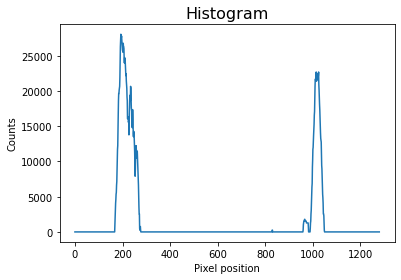

In [15]:
#draw histogram to obtain start of right lane pixels and start of left lane pixels
histogram = hist(mm)
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)
midpoint = histogram.shape[0]//2
#start of left lane pixels
leftx_base = np.argmax(histogram[:midpoint])
#start of right lane pixels
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print('Leftx Base = ', leftx_base,'Rightx_Base = ', rightx_base)

In [16]:
left_fit = None
right_fit = None
binary = None
nonzero = None
nonzerox = None
nonzeroy = None
clear_visibility = True
dir = []
left_curve_img = mpimg.imread('./images/left_turn.png')
right_curve_img = mpimg.imread('./images/right_turn.png')
keep_straight_img = mpimg.imread('./images/straight.png')
#left_curve_img ,right_curve_img ,keep_straight_img are png images so we must use cv2.normalize to draw them on images

left_curve_img = cv2.normalize(src=left_curve_img, dst=None, alpha=0, beta=255,
                                            norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
right_curve_img = cv2.normalize(src=right_curve_img, dst=None, alpha=0, beta=255,
                                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
keep_straight_img = cv2.normalize(src=keep_straight_img, dst=None, alpha=0, beta=255,
                                               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# Number of sliding windows
nwindows = 9
 # Width of the the windows +/- margin
margin = 100
# Mininum number of pixels found to recenter window
minpix = 50

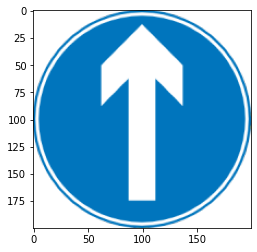

In [17]:
#checking that left_curve_img ,right_curve_img ,keep_straight_img are readed correctely 
plt.imshow(left_curve_img)
plt.imshow(right_curve_img)
plt.imshow(keep_straight_img)

In [18]:
def extract_features(img):
  # Height of of windows - based on nwindows and image shape
  window_height = np.int(img.shape[0] // nwindows)

  # Identify the x and y positions of all nonzero pixel in the image
  nonzero = img.nonzero()
  return nonzero
nonzero = extract_features(mm)
nonzerox = np.array(nonzero[1])
nonzeroy = np.array(nonzero[0])

C:\Users\OMARNA~1\AppData\Local\Temp/ipykernel_9860/1300778742.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_height = np.int(img.shape[0] // nwindows)


In [19]:
#return indecies of non zero pixels in the sliding window
def pixels_in_window(center, margin, height,nonzerox,nonzeroy):
    topleft = (center[0] - margin, center[1] - height // 2)
    bottomright = (center[0] + margin, center[1] + height // 2)
    
    #x coordinates of pixels that lie inside the window
    condx = (topleft[0] <= nonzerox) & (nonzerox <= bottomright[0])
    #y coordinates of pixels that lie inside the window
    condy = (topleft[1] <= nonzeroy) & (nonzeroy <= bottomright[1])
    return nonzerox[condx & condy], nonzeroy[condx & condy]

In [ ]:
def find_lane_pixels(img,nwindows,window_height,margin,minpix,nonzerox,nonzeroy):
        #make sure that image is two dimensional
    assert (len(img.shape) == 2)

        # Create an output image to draw on and visualize the result
        #(img, img, img) for rgb
    out_img = np.dstack((img, img, img))

    histogram = hist(img)
    midpoint = histogram.shape[0] // 2

    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Current position to be update later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    y_current = img.shape[0] + window_height // 2

        # Create empty lists to reveice left and right lane pixel
    leftx, lefty, rightx, righty = [], [], [], []

        # Step through the windows one by one
    for _ in range(nwindows):
        y_current -= window_height
        center_left = (leftx_current, y_current)
        center_right = (rightx_current, y_current)

        good_left_x, good_left_y = pixels_in_window(center_left, margin, window_height,nonzerox,nonzeroy)
        good_right_x, good_right_y = pixels_in_window(center_right, margin, window_height,nonzerox,nonzeroy)

            # Append these indices to the lists
        leftx.extend(good_left_x)
        lefty.extend(good_left_y)
        rightx.extend(good_right_x)
        righty.extend(good_right_y)

        if len(good_left_x) > minpix:
            leftx_current = np.int32(np.mean(good_left_x))
        if len(good_right_x) > minpix:
            rightx_current = np.int32(np.mean(good_right_x))

    return leftx, lefty, rightx, righty, out_img

In [ ]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(mm,nwindows,window_height,margin,minpix,nonzerox,nonzeroy)

In [ ]:
def measure_curvature(left_fitt,right_fitt):
    ym = 30 / 720
    xm = 3.7 / 700

    left_fitt = left_fitt.copy()
    right_fitt = right_fitt.copy()
    y_eval = 700 * ym

    # Compute R_curve (radius of curvature)
    left_curveR = ((1 + (2 * left_fitt[0] * y_eval + left_fitt[1]) ** 2) ** 1.5) / np.absolute(2 * left_fitt[0])
    right_curveR = ((1 + (2 * right_fitt[0] * y_eval + right_fitt[1]) ** 2) ** 1.5) / np.absolute(2 * right_fitt[0])

    xl = np.dot(left_fitt, [700 ** 2, 700, 1])
    xr = np.dot(right_fitt, [700 ** 2, 700, 1])
    pos = (1280 // 2 - (xl + xr) // 2) * xm
    return left_curveR, right_curveR, pos

In [ ]:
def fit_poly(img,leftx, lefty, rightx, righty, out_img):


    if len(lefty) > 1500:
            #2 in polyfit stands for quadratic because we have curved lane
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(righty) > 1500:
            # 2 in polyfit stands for quadratic because we have curved lane
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting


        #initialize maxy and miny
    maxy = img.shape[0] - 1
    miny = img.shape[0] // 3


    if len(lefty):
        maxy = max(maxy, np.max(lefty))
        miny = min(miny, np.min(lefty))

    if len(righty):
        maxy = max(maxy, np.max(righty))
        miny = min(miny, np.min(righty))

    ploty = np.linspace(miny, maxy, img.shape[0])

        #equation of curve

    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

        # Visualization
    for i, y in enumerate(ploty):
        l = int(left_fitx[i])
        r = int(right_fitx[i])
        y = int(y)
        #green lines
        cv2.line(out_img, (l, y), (r, y), (0, 255, 0))

    return out_img ,left_fit,right_fit

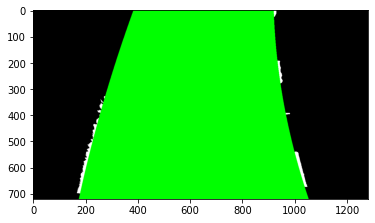

In [ ]:
out_img,left_fit,right_fit=fit_poly(mm,leftx, lefty, rightx, righty, out_img)
plt.imshow(out_img)

In [ ]:
def plot(out_img,left_fit,right_fit):

    out_im = np.copy(out_img)
    np.set_printoptions(precision=6, suppress=True)
    lR, rR, pos = measure_curvature(left_fit,right_fit)

    value = None
    if abs(left_fit[0]) > abs(right_fit[0]):
        value = left_fit[0]
    else:
        value = right_fit[0]

    if abs(value) <= 0.00015:
        dir.append('F')
    elif value < 0:
        dir.append('L')
    else:
        dir.append('R')

    if len(dir) > 10:
            dir.pop(0)

    W = 400
    H = 500
    
    widget = np.copy(out_im[:H, :W])
    widget //= 2
    widget[0, :] = [0, 0, 255]
    widget[-1, :] = [0, 0, 255]
    widget[:, 0] = [0, 0, 255]
    widget[:, -1] = [0, 0, 255]
    out_im[:H, :W] = widget

    direction = max(set(dir), key=dir.count)
    msg = "Keep Straight Ahead"
    curvature_msg = "Curvature = {:.0f} m".format(min(lR, rR))
    if direction == 'L':
        y, x = left_curve_img[:, :, 3].nonzero()
        out_im[y, x - 100 + W // 2] = left_curve_img[y, x, :3]
        msg = "Left Curve Ahead"
    if direction == 'R':
        y, x = right_curve_img[:, :, 3].nonzero()
        out_im[y, x - 100 + W // 2] = right_curve_img[y, x, :3]
        msg = "Right Curve Ahead"
    if direction == 'F':
        y, x = keep_straight_img[:, :, 3].nonzero()
        out_im[y, x - 100 + W // 2] = keep_straight_img[y, x, :3]

    cv2.putText(out_im, msg, org=(10, 240), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255),
                    thickness=2)
    if direction in 'LR':
        cv2.putText(out_im, curvature_msg, org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                        color=(255, 255, 255), thickness=2)

    cv2.putText(
            out_im,
            "Good Lane Keeping",
            org=(10, 400),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.2,
            color=(0, 255, 0),
            thickness=2)

    cv2.putText(
            out_im,
            "Vehicle is {:.2f} m away from center".format(pos),
            org=(10, 450),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.66,
            color=(255, 255, 255),
            thickness=2)

    return out_im

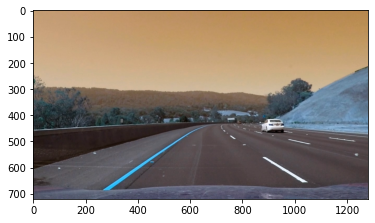

In [ ]:

plt.imshow(im)

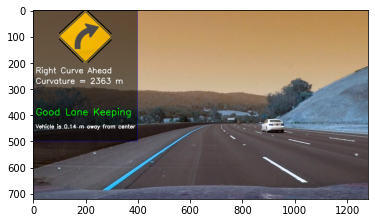

In [ ]:
i=plot(im,left_fit,right_fit)
plt.imshow(i)

In [ ]:
def backward( im, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
    
    return cv2.warpPerspective(im, M_inv, img_size, flags=flags)

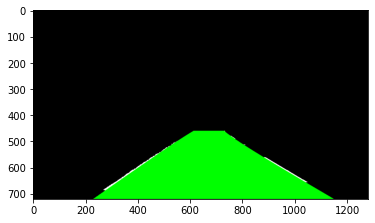

In [ ]:
# i,left_f,right_f=fit_poly(i,leftx, lefty, rightx, righty, i)
out_img2=backward( out_img, img_size=(1280, 720), flags=cv2.INTER_LINEAR)
plt.imshow(out_img2)

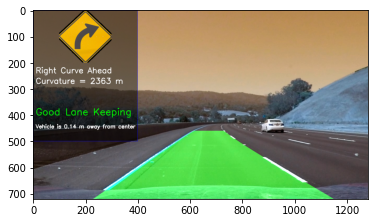

In [ ]:
i = cv2.addWeighted(i, 1, out_img2, 0.6, 0)
plt.imshow(i)